# Challenge IV time-series

In [1]:
!pip install --upgrade torch pytorch-lightning==1.9.4 pytorch-forecasting torchdata optuna optuna-integration numpy==1.25

In [2]:
#Libraries required
#Data Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch Lighting
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner

#Pytorch Forcasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import  QuantileLoss
#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

#Utils
import pickle
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import copy
import logging
import os
from typing import Any, Dict, Tuple, Union

import lightning.pytorch as pl
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner
import numpy as np
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import optuna.logging
import statsmodels.api as sm
import torch
from torch.utils.data import DataLoader

from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss

optuna_logger = logging.getLogger("optuna")


# need to inherit from callback for this to work
class PyTorchLightningPruningCallbackAdjusted(PyTorchLightningPruningCallback):
    pass


def optimize_hyperparameters(
    train_dataloaders: DataLoader,
    val_dataloaders: DataLoader,
    model_path: str,
    max_epochs: int = 20,
    n_trials: int = 100,
    timeout: float = 3600 * 8.0,  # 8 hours
    gradient_clip_val_range: Tuple[float, float] = (0.01, 100.0),
    hidden_size_range: Tuple[int, int] = (16, 265),
    hidden_continuous_size_range: Tuple[int, int] = (8, 64),
    attention_head_size_range: Tuple[int, int] = (1, 4),
    dropout_range: Tuple[float, float] = (0.1, 0.3),
    learning_rate_range: Tuple[float, float] = (1e-5, 1.0),
    use_learning_rate_finder: bool = True,
    trainer_kwargs: Dict[str, Any] = {},
    log_dir: str = "lightning_logs",
    study: optuna.Study = None,
    verbose: Union[int, bool] = None,
    pruner: optuna.pruners.BasePruner = optuna.pruners.SuccessiveHalvingPruner(),
    **kwargs,
) -> optuna.Study:
    """
    Optimize Temporal Fusion Transformer hyperparameters.

    Run hyperparameter optimization. Learning rate for is determined with
    the PyTorch Lightning learning rate finder.

    Args:
        train_dataloaders (DataLoader): dataloader for training model
        val_dataloaders (DataLoader): dataloader for validating model
        model_path (str): folder to which model checkpoints are saved
        max_epochs (int, optional): Maximum number of epochs to run training. Defaults to 20.
        n_trials (int, optional): Number of hyperparameter trials to run. Defaults to 100.
        timeout (float, optional): Time in seconds after which training is stopped regardless of number of epochs
            or validation metric. Defaults to 3600*8.0.
        hidden_size_range (Tuple[int, int], optional): Minimum and maximum of ``hidden_size`` hyperparameter. Defaults
            to (16, 265).
        hidden_continuous_size_range (Tuple[int, int], optional):  Minimum and maximum of ``hidden_continuous_size``
            hyperparameter. Defaults to (8, 64).
        attention_head_size_range (Tuple[int, int], optional):  Minimum and maximum of ``attention_head_size``
            hyperparameter. Defaults to (1, 4).
        dropout_range (Tuple[float, float], optional):  Minimum and maximum of ``dropout`` hyperparameter. Defaults to
            (0.1, 0.3).
        learning_rate_range (Tuple[float, float], optional): Learning rate range. Defaults to (1e-5, 1.0).
        use_learning_rate_finder (bool): If to use learning rate finder or optimize as part of hyperparameters.
            Defaults to True.
        trainer_kwargs (Dict[str, Any], optional): Additional arguments to the
            `PyTorch Lightning trainer <https://pytorch-lightning.readthedocs.io/en/latest/trainer.html>`_ such
            as ``limit_train_batches``. Defaults to {}.
        log_dir (str, optional): Folder into which to log results for tensorboard. Defaults to "lightning_logs".
        study (optuna.Study, optional): study to resume. Will create new study by default.
        verbose (Union[int, bool]): level of verbosity.
            * None: no change in verbosity level (equivalent to verbose=1 by optuna-set default).
            * 0 or False: log only warnings.
            * 1 or True: log pruning events.
            * 2: optuna logging level at debug level.
            Defaults to None.
        pruner (optuna.pruners.BasePruner, optional): The optuna pruner to use.
            Defaults to optuna.pruners.SuccessiveHalvingPruner().

        **kwargs: Additional arguments for the :py:class:`~TemporalFusionTransformer`.

    Returns:
        optuna.Study: optuna study results
    """
    assert isinstance(train_dataloaders.dataset, TimeSeriesDataSet) and isinstance(
        val_dataloaders.dataset, TimeSeriesDataSet
    ), "dataloaders must be built from timeseriesdataset"

    logging_level = {
        None: optuna.logging.get_verbosity(),
        0: optuna.logging.WARNING,
        1: optuna.logging.INFO,
        2: optuna.logging.DEBUG,
    }
    optuna_verbose = logging_level[verbose]
    optuna.logging.set_verbosity(optuna_verbose)

    loss = kwargs.get(
        "loss", QuantileLoss()
    )  # need a deepcopy of loss as it will otherwise propagate from one trial to the next

    # create objective function
    def objective(trial: optuna.Trial) -> float:
        # Filenames for each trial must be made unique in order to access each checkpoint.
        checkpoint_callback = ModelCheckpoint(
            dirpath=os.path.join(model_path, "trial_{}".format(trial.number)), filename="{epoch}", monitor="val_loss"
        )

        learning_rate_callback = LearningRateMonitor()
        logger = TensorBoardLogger(log_dir, name="optuna", version=trial.number)
        gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
        default_trainer_kwargs = dict(
            accelerator="auto",
            max_epochs=max_epochs,
            gradient_clip_val=gradient_clip_val,
            callbacks=[
                learning_rate_callback,
                checkpoint_callback,
                PyTorchLightningPruningCallbackAdjusted(trial, monitor="val_loss"),
            ],
            logger=logger,
            enable_progress_bar=optuna_verbose < optuna.logging.INFO,
            enable_model_summary=[False, True][optuna_verbose < optuna.logging.INFO],
        )
        default_trainer_kwargs.update(trainer_kwargs)
        trainer = pl.Trainer(
            **default_trainer_kwargs,
        )

        # create model
        hidden_size = trial.suggest_int("hidden_size", *hidden_size_range, log=True)
        kwargs["loss"] = copy.deepcopy(loss)
        model = TemporalFusionTransformer.from_dataset(
            train_dataloaders.dataset,
            dropout=trial.suggest_uniform("dropout", *dropout_range),
            hidden_size=hidden_size,
            hidden_continuous_size=trial.suggest_int(
                "hidden_continuous_size",
                hidden_continuous_size_range[0],
                min(hidden_continuous_size_range[1], hidden_size),
                log=True,
            ),
            attention_head_size=trial.suggest_int("attention_head_size", *attention_head_size_range),
            log_interval=-1,
            **kwargs,
        )
        # find good learning rate
        if use_learning_rate_finder:
            lr_trainer = pl.Trainer(
                gradient_clip_val=gradient_clip_val,
                accelerator="auto",
                logger=False,
                enable_progress_bar=False,
                enable_model_summary=False,
            )
            tuner = Tuner(lr_trainer)
            res = tuner.lr_find(
                model,
                train_dataloaders=train_dataloaders,
                val_dataloaders=val_dataloaders,
                early_stop_threshold=10000,
                min_lr=learning_rate_range[0],
                num_training=100,
                max_lr=learning_rate_range[1],
            )

            loss_finite = np.isfinite(res.results["loss"])
            if loss_finite.sum() > 3:  # at least 3 valid values required for learning rate finder
                lr_smoothed, loss_smoothed = sm.nonparametric.lowess(
                    np.asarray(res.results["loss"])[loss_finite],
                    np.asarray(res.results["lr"])[loss_finite],
                    frac=1.0 / 10.0,
                )[min(loss_finite.sum() - 3, 10) : -1].T
                optimal_idx = np.gradient(loss_smoothed).argmin()
                optimal_lr = lr_smoothed[optimal_idx]
            else:
                optimal_idx = np.asarray(res.results["loss"]).argmin()
                optimal_lr = res.results["lr"][optimal_idx]
            optuna_logger.info(f"Using learning rate of {optimal_lr:.3g}")
            # add learning rate artificially
            model.hparams.learning_rate = trial.suggest_uniform("learning_rate", optimal_lr, optimal_lr)
        else:
            model.hparams.learning_rate = trial.suggest_loguniform("learning_rate", *learning_rate_range)

        # fit
        trainer.fit(model, train_dataloaders=train_dataloaders, val_dataloaders=val_dataloaders)

        # report result
        return trainer.callback_metrics["val_loss"].item()

    # setup optuna and run
    if study is None:
        study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    return study

In [4]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
device

device(type='cuda')

In [7]:
df_x_train = pd.read_csv('/content/drive/MyDrive/Deep Learning/Semana 6/Challenge IV/X_train.csv')

In [8]:
df_x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241696 entries, 0 to 241695
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       241696 non-null  int64  
 1   SAMPLE_ID        241696 non-null  int64  
 2   GROUP_ID         241696 non-null  int64  
 3   ASSET_ID         241696 non-null  int64  
 4   MEASURE_TYPE     241696 non-null  int64  
 5   MEASURE_VALUE    170352 non-null  float64
 6   MEASURE_WEEKDAY  241696 non-null  int64  
 7   MEASURE_WEEK     241696 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 14.8 MB


In [12]:
df_x_train.head()

,Unnamed: 0,SAMPLE_ID,GROUP_ID,ASSET_ID,MEASURE_TYPE,MEASURE_VALUE,MEASURE_WEEKDAY,MEASURE_WEEK
0,0,1,2,1,1,NaN,1,1
1,1,1,2,1,2,NaN,1,1
2,2,1,2,1,3,19.0,1,1
3,3,1,2,1,4,0.0,1,1
4,4,1,2,1,1,NaN,2,1


(array([25564., 23240., 23240., 25564., 23240., 23240., 25564., 23240.,
        23240., 25564.]),
 array([  1. ,  11.3,  21.6,  31.9,  42.2,  52.5,  62.8,  73.1,  83.4,
         93.7, 104. ]),
 <BarContainer object of 10 artists>)

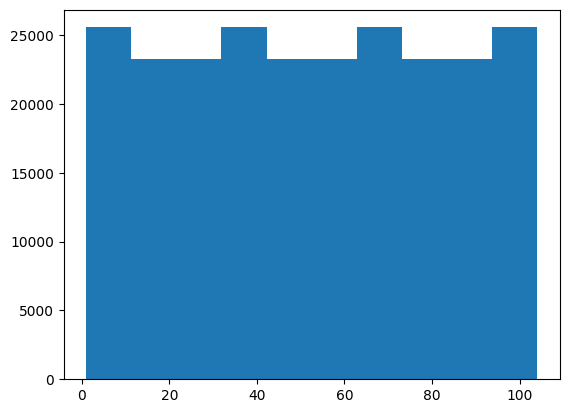

In [13]:
plt.hist(df_x_train['MEASURE_WEEK'])

In [9]:
df_train = df_x_train.copy(deep=True)

In [10]:
y_train= pd.read_csv('/content/drive/MyDrive/Deep Learning/Semana 6/Challenge IV/y_train.csv')

In [11]:
y_train

,SAMPLE_ID,PRODUCTION_GROUP_2,PRODUCTION_GROUP_3
0,1,3850220.0,9019860.320
1,2,3793240.0,8568867.304
2,3,3870570.0,8549258.912
3,4,3801380.0,8451216.952
4,5,3752540.0,8323762.404
...,...,...,...
99,100,3984530.0,9372811.376
100,101,3976390.0,9588503.688
101,102,3903130.0,9598307.884
102,103,3927550.0,9745370.824
